#  Прогнозирование заказов такси. Проект спринта "Временные ряды"

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# обновлял библиотеку, потом закомментировал
#pip install --upgrade scikit-learn

In [2]:
# импорт библиотек и инструментов
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import cross_val_predict

In [3]:
# Загрузка данных и предварительный просмотр
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data.head(10))
display(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [4]:
# Выполним сортировку и проверим, что временные метки упорядочены по возрастанию
data = data.sort_index()
display(data.index.is_monotonic_increasing)
display(data.info())

True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [5]:
# Проверка на пропущенные значения
print(data.isnull().sum())

num_orders    0
dtype: int64


In [6]:
# Ресемплирование данных по одному часу
data = data.resample('h').sum()

# Просмотр первых строк данных
display(data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


###### Вывод по шагу 1
- данные загружены
- выполнены сортировка и проверка упорядоченности
- выполнена проверка на пропущенные значения
- выполнено ресемплирование по одному часу

## Анализ

In [7]:
# Основные статистики
display(data.describe())

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


###### Построение временного ряда 

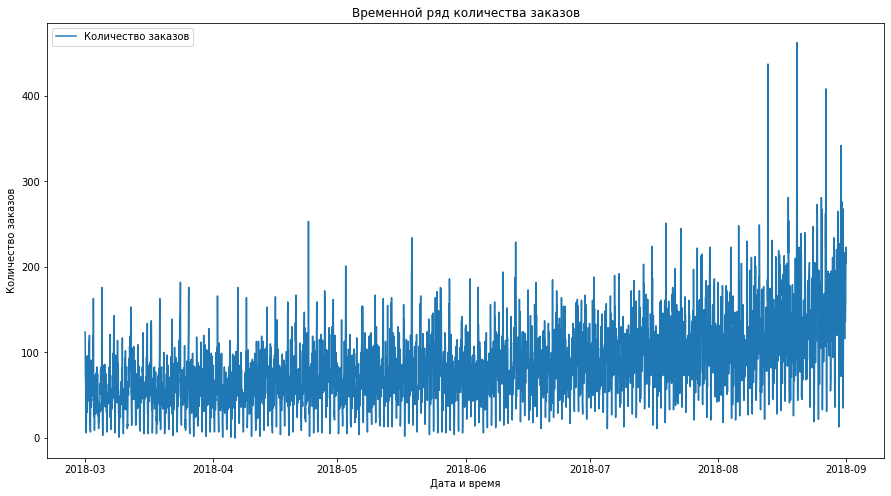

In [8]:
# Построение графика временного ряда
plt.figure(figsize=(15, 8))
plt.plot(data.index, data['num_orders'], label='Количество заказов')
plt.title('Временной ряд количества заказов')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

###### Построение временного ряда со скользящим средним

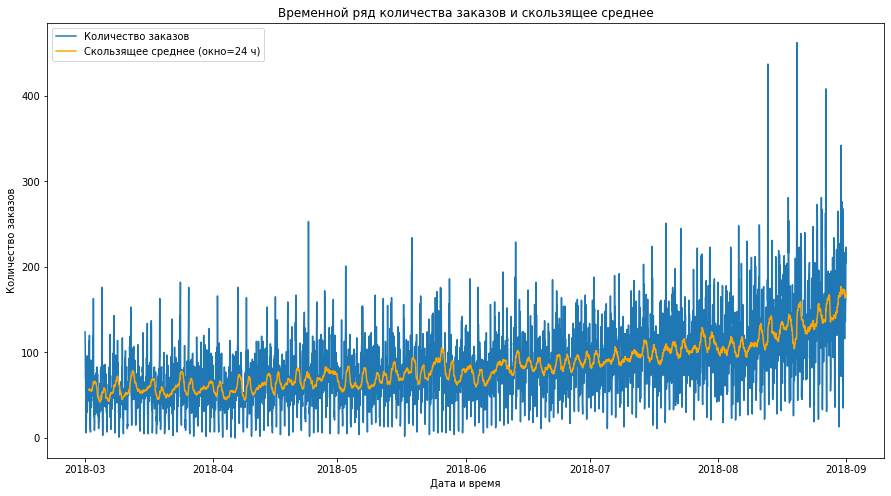

In [9]:
# Определяем окно для скользящего среднего (например, 24 часа)
rolling_window = 24

# Вычисление скользящего среднего
data['rolling_mean'] = data['num_orders'].rolling(window=rolling_window).mean()

# Построение графика временного ряда и скользящего среднего
plt.figure(figsize=(15, 8))
plt.plot(data.index, data['num_orders'], label='Количество заказов')
plt.plot(data.index, data['rolling_mean'], color='orange',
         label=f'Скользящее среднее (окно={rolling_window} ч)')
plt.title('Временной ряд количества заказов и скользящее среднее')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

###### Построение графиков тренда, сезонности и остатков

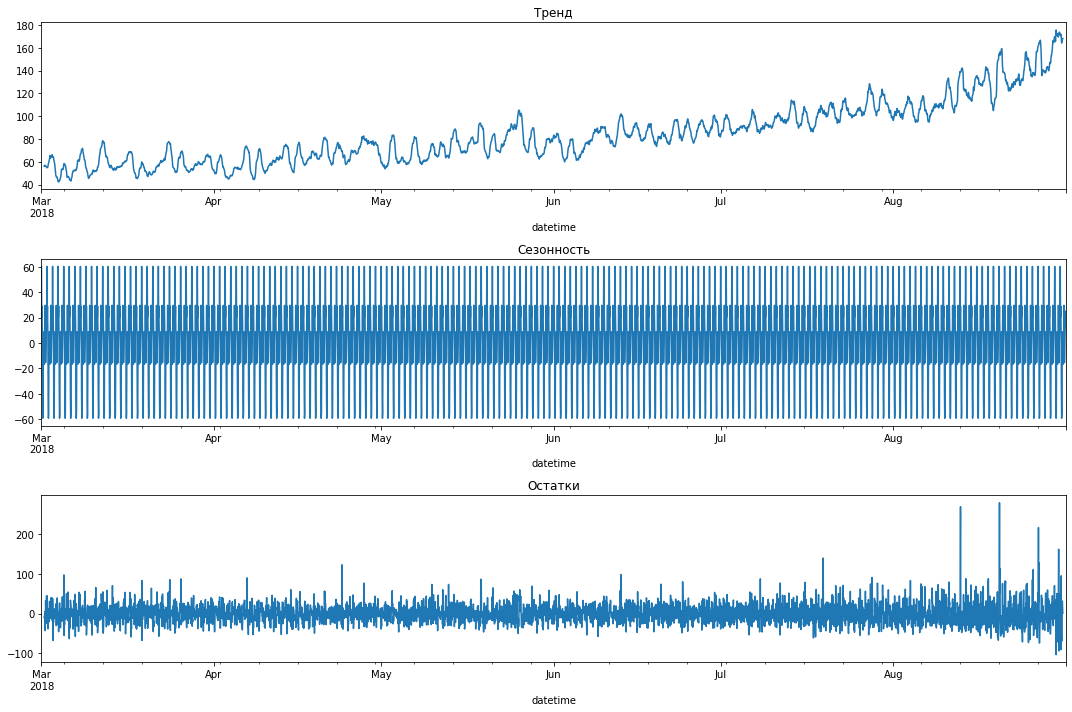

In [10]:
# Разложение временного ряда
decomposed = seasonal_decompose(data['num_orders'], model='additive', period=24)

# Построение графиков тренда, сезонности и остатков
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')

plt.tight_layout()
plt.show()

###### Построение графиков тренда, сезонности и остатков для последнего месяца (август 2018 г.)

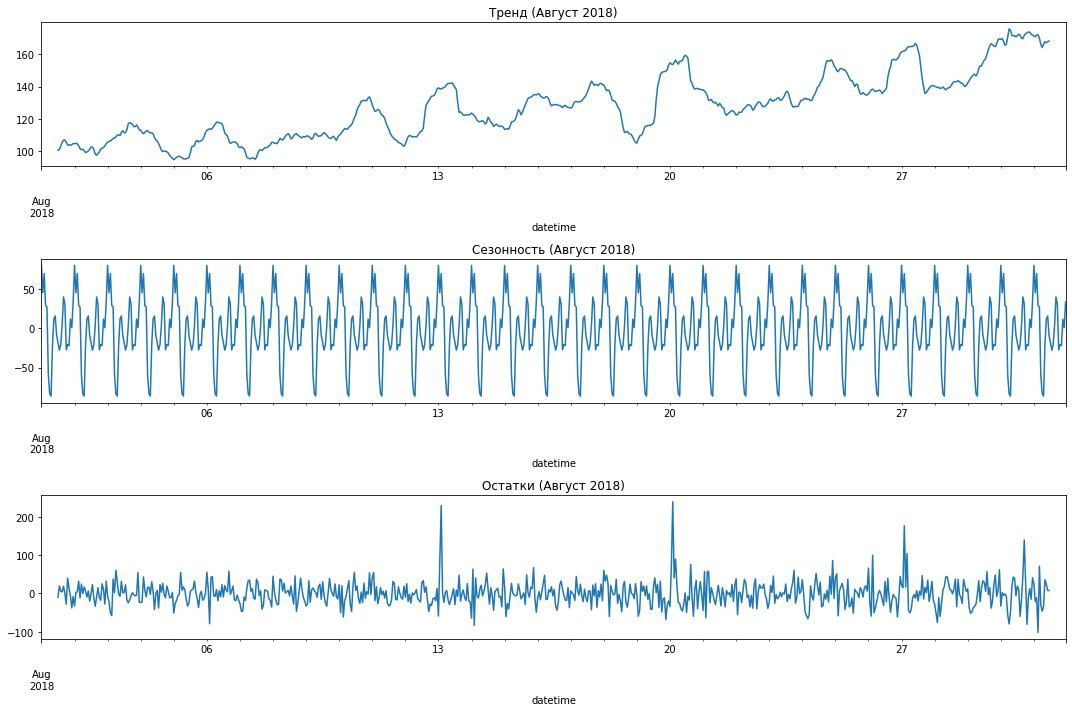

In [11]:
# Фильтрация данных для последнего месяца (август)
last_month_data = data['2018-08-01':'2018-08-31']

# Разложение временного ряда за последний месяц
decomposed = seasonal_decompose(last_month_data['num_orders'], model='additive', period=24)

# Построение графиков тренда, сезонности и остатков для последнего месяца
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд (Август 2018)')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность (Август 2018)')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки (Август 2018)')

plt.tight_layout()
plt.show()

###### Построение графиков тренда, сезонности и остатков для последней недели (25-31 августа 2018 г.)

In [12]:
display(f"Последняя дата в датасете: {data.index.max()}")

'Последняя дата в датасете: 2018-08-31 23:00:00'

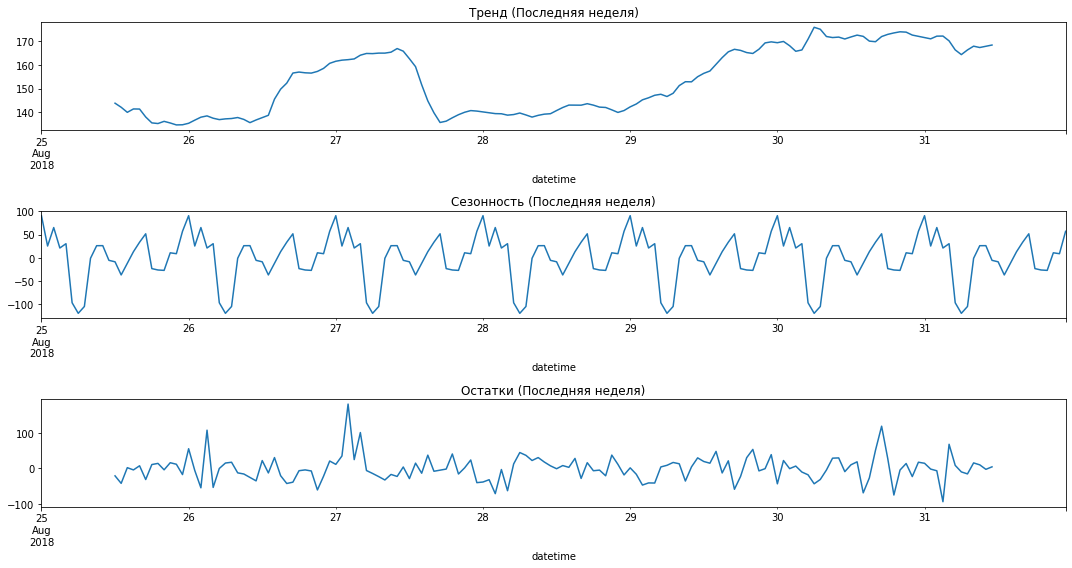

In [13]:
# Фильтрация данных для последней недели
last_week_data = data['2018-08-25':'2018-08-31']

# Разложение временного ряда за последнюю неделю
decomposed = seasonal_decompose(last_week_data['num_orders'], model='additive', period=24)

# Построение графиков тренда, сезонности и остатков для последней недели
plt.figure(figsize=(15, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд (Последняя неделя)')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность (Последняя неделя)')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки (Последняя неделя)')

plt.tight_layout()
plt.show()

- Со временем дисперсия временного ряда увеличивается. Анализ тренда показывает, что количество заказов такси растет. Каждый день наблюдается активный спрос на такси в ночное время, это видно по пикам на графике, а утром потребность в такси уменьшается.

- Этот временной ряд не является стационарным, поскольку он содержит тренд, который меняется со временем. Это можно подтвердить с помощью теста Дики-Фуллера.

###### Тест Дики-Фуллера

Нулевая гипотеза утверждает, что временной ряд не является стационарным, тогда как альтернативная гипотеза предполагает, что ряд стационарен.

In [14]:
# Применение теста Дики-Фуллера для проверки стационарности
p_value = adfuller(data['num_orders'])[1]
print('P-значение =', p_value)

# Интерпретация результатов теста
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера.')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера.')

P-значение = 0.028940051402612906
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера.


Не смотря на предварительный вывод о нестационарности, результат теста по критерию Дики-Фуллера показывает, что ряд стационарен


- Возможные причины разногласий
    - Периодичность тренда: Возможно, тренд в нашем временном ряду имеет периодические компоненты, которые не столь явны на первый взгляд. Например, тренд может быть неявным или иметь слабовыраженные сезонные колебания.

    - Декомпозиция тренда: Временной ряд может иметь тренд, но также и сезонные компоненты, которые могут быть устранены в процессе декомпозиции. В этом случае тест Дики-Фуллера может показать, что остаточные компоненты стационарны, несмотря на наличие тренда.

    - Проблемы с данными: Если данные имеют аномалии, выбросы или другие особенности, это может повлиять на результаты теста.

    - Выбор параметров теста: Тест Дики-Фуллера имеет различные вариации (с трендом, без тренда и т.д.), и выбор параметров теста также может влиять на результаты. Например, тест с трендом проверяет более сложную стационарность, чем тест без тренда.

###### Добавление новых признаков

- Так как видна ежедневная сезонность - то точно понадобится признак 'day'.
- В отдельные часы заказов больше, поэтому добавим признак 'hour'
- Тренд показывает, что к концу недели и в середине идет увеличение заказов - добавим признак 'day_of_week'.
- Из месяца в месяц данные отличаются - добавим признак 'month'.

In [15]:
# Создаем новые столбцы
data['hour'] = data.index.hour
data['day'] = data.index.day
data['day_of_week'] = data.index.day_name()
data['month'] = data.index.month_name()
data.drop(columns=['rolling_mean'], inplace=True)

# Выводим первые строки для проверки
display(data.head())

,num_orders,hour,day,day_of_week,month
datetime,,,,,
2018-03-01 00:00:00,124,0,1,Thursday,March
2018-03-01 01:00:00,85,1,1,Thursday,March
2018-03-01 02:00:00,71,2,1,Thursday,March
2018-03-01 03:00:00,66,3,1,Thursday,March
2018-03-01 04:00:00,43,4,1,Thursday,March


###### Вывод по шагу 2
- данные проанализированы
- выявлены тренды и сезонность
- данные были подготовлены к обучению
- добавлены новые признаки: час, число, день недели, месяц

## Обучение

In [16]:
# Преобразуем в тип 'category' час, день недели, месяц
data['hour'] = data['hour'].astype('category')
data['day_of_week'] = data['day_of_week'].astype('category')
data['month'] = data['month'].astype('category')

In [17]:
# Определение X и y
X = data.drop('num_orders', axis=1)  # Признаки
y = data['num_orders']  # Целевой признак

# Разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=42)

# Подготовка для TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

###### CatBoostRegressor

In [18]:
# Определим категориальные признаки
categorical_features = ['hour', 'day_of_week', 'month']

# Инициализируем и обучаем модель
model_cbr = CatBoostRegressor(verbose=0)
model_cbr.fit(X_train, y_train, cat_features=categorical_features)

# Получаем предсказания и рассчитываем RMSE на тренировочной выборке
predictions_cbr = model_cbr.predict(X_train)
rmse_cbr = mean_squared_error(y_train, predictions_cbr, squared=False)

print(f'RMSE на тренировочной выборке: {round(rmse_cbr, 2)}')

RMSE на тренировочной выборке: 18.78


###### LightGBM

In [19]:
# Инициализация модели LGBMRegressor
model_lgbm = lgb.LGBMRegressor()

# Обучение модели на тренировочных данных
model_lgbm.fit(X_train, y_train, verbose=False)

# Получение предсказаний на тренировочных данных
predictions_lgbm = model_lgbm.predict(X_train)

# Расчет RMSE (корень из среднеквадратичной ошибки) на тренировочных данных
rmse_lgbm = mean_squared_error(y_train, predictions_lgbm, squared=False)

# Вывод значения RMSE
print(f'RMSE на тренировочной выборке: {round(rmse_lgbm, 2)}')

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


RMSE на тренировочной выборке: 15.69


###### DecisionTreeRegressor

In [20]:
# Определение трансформеров для обработки категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['day_of_week', 'month']),
        ('num', SimpleImputer(strategy='mean'), ['day'])
    ],
    remainder='passthrough'
)

# Создание и настройка пайплайна
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Определение параметров для поиска
parameters = {'model__max_depth': range(1, 11, 2)}

# Настройка GridSearchCV
gsearch = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=tscv, n_jobs=-1)
gsearch.fit(X_train, y_train)

# Вывод лучших параметров
print(f'Лучшие параметры: {gsearch.best_params_}')

Лучшие параметры: {'model__max_depth': 7}


In [21]:
predictions_dtr = gsearch.predict(X_train)
rmse_dtr = mean_squared_error(y_train, predictions_dtr, squared=False)
print(f'RMSE на тренировочной выборке: {round(rmse_dtr, 2)}')

RMSE на тренировочной выборке: 22.85


###### Сравнение моделей

In [22]:
# определяем RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# CatBoostRegressor
model_cbr = CatBoostRegressor(cat_features=categorical_features, verbose=0)
cv_scores_cbr = cross_val_score(model_cbr, X_train, y_train, cv=tscv, scoring=rmse_scorer)
mean_rmse_cbr = np.mean(cv_scores_cbr)

# LightGBM
cv_scores_lgbm = cross_val_score(model_lgbm, X_train, y_train, cv=tscv, scoring=rmse_scorer)
mean_rmse_lgbm = np.mean(cv_scores_lgbm)

# DecisionTreeRegressor
cv_scores_dtr = cross_val_score(gsearch, X_train, y_train, cv=tscv, scoring=rmse_scorer)
mean_rmse_dtr = np.mean(cv_scores_dtr)

# Создание таблицы с результатами
results_cv = pd.DataFrame({
    'Модель': ['CatBoostRegressor', 'LGBMRegressor', 'DecisionTreeRegressor'],
    'Среднее RMSE на кросс-валидации': [mean_rmse_cbr, mean_rmse_lgbm, mean_rmse_dtr]
})

# вывод результатов
display(results_cv)

,Модель,Среднее RMSE на кросс-валидации
0,CatBoostRegressor,30.930218
1,LGBMRegressor,32.263985
2,DecisionTreeRegressor,35.089490


###### Вывод по шагу 3

- Категориальные признаки hour, day_of_week, и month были преобразованы в тип 'category'.
- Данные были разделены на тренировочную и тестовую выборки.
- Для кросс-валидации был использован метод TimeSeriesSplit, который учитывает временную структуру данных.
- Были обучены модели: CatBoostRegressor, LightGBMRegressor, DecisionTreeRegressor
- Модель CatBoostRegressor показала наилучший результат по кросс-валидации, с самым низким значением RMSE = 30.9

## Тестирование

In [23]:
# Обучение модели на тренировочных данных
model_cbr = CatBoostRegressor(cat_features=categorical_features, verbose=0)
model_cbr.fit(X_train, y_train)

# Предсказания на тестовой выборке
test_predictions_cbr = model_cbr.predict(X_test)
test_rmse_cbr = mean_squared_error(y_test, test_predictions_cbr, squared=False)
print(f'CatBoostRegressor: RMSE на тестовой выборке: {round(test_rmse_cbr, 2)}')

CatBoostRegressor: RMSE на тестовой выборке: 40.14


На тестовых данных модель CatBoostRegressor показала RMSE = 40.14, что меньше 48 и удовлетворяет условию задачи. Посмотрим на график, чтобы было нагляднее

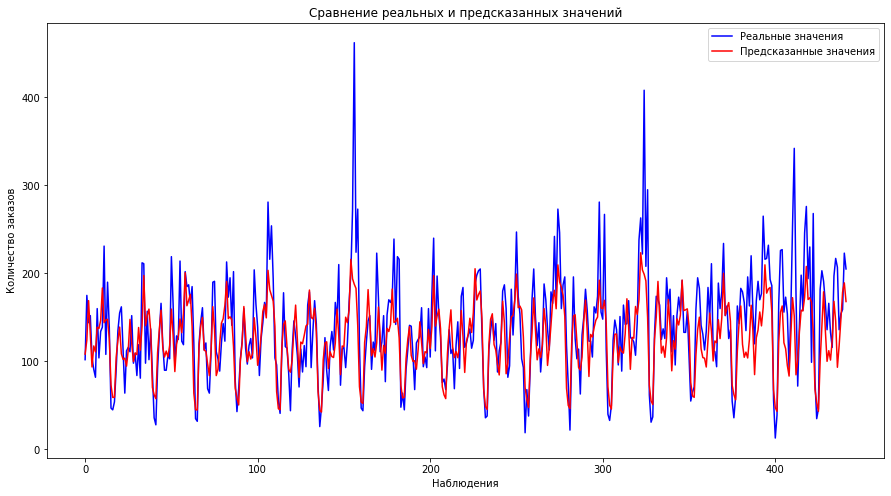

In [24]:
# Создаем график
plt.figure(figsize=(15, 8))
plt.plot(y_test.values, label='Реальные значения', color='blue')
plt.plot(test_predictions_cbr, label='Предсказанные значения', color='red')

# Настройка графика
plt.title('Сравнение реальных и предсказанных значений')
plt.xlabel('Наблюдения')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

###### Вывод по шагу 4
- На этом этапе мы протестировали лучшую модель (CatBoostRegressor) на тестовых данных и оценили производительность с помощью метрики RMSE
- Мы получили значение RMSE у модели CatBoostRegressor равное 40.14, это значение меньше порога в 48, который был установлен в условии задачи, что говорит о хорошем качестве модели
- На графике, который был построен, показано сравнение реальных значений и предсказанных моделью значений

## Общий вывод

###### 1. Подготовка данных
- В этом этапе была выполнена загрузка данных и их предварительная обработка:

    - Загрузка данных: Данные о заказах такси были успешно загружены и проверены. В исходном наборе данных не было пропущенных значений, а временные метки были упорядочены.
    - Ресемплирование: Данные были ресемплированы по одному часу для приведения временного ряда к нужной частоте.
    - Вывод: На основе предварительного анализа данные были подготовлены для дальнейшего анализа и моделирования.

###### 2. Анализ данных
- На этом этапе был проведен детальный анализ временного ряда:

    - Статистический обзор: Были представлены основные статистики данных, такие как среднее, стандартное отклонение, минимальные и максимальные значения.
    - Визуализация временного ряда: Построены графики временного ряда, скользящего среднего, а также разложение на тренд, сезонность и остатки.
    - Сезонность и тренды: Выявлено, что данные содержат явные тренды и сезонности, такие как увеличение количества заказов в ночное время и активный спрос на выходных.
    - Тест Дики-Фуллера: Тест показал, что ряд стационарен, что важно для дальнейшего анализа и моделирования.
    - Добавление признаков: Введены дополнительные признаки, такие как час, день недели, и месяц, что позволит улучшить модели за счет использования временной информации.

###### 3. Обучение моделей
- CatBoostRegressor:
    - Кросс-валидация: Модель показала средний RMSE на валидации 30.93, что является хорошим результатом.
    - Описание: Модель продемонстрировала лучшие результаты на кросс-валидации среди всех протестированных моделей



- LightGBMRegressor:
    - Кросс-валидация: Эта модель продемонстрировала средний RMSE на валидации 32.06, что также является достойным результатом.
    - Описание: Несмотря на то, что модель не была лидером на этапе кросс-валидации, она показала стабильные результаты и заслуживает внимания.



- DecisionTreeRegressor:
    - Кросс-валидация: Средний RMSE на валидации составил 35.31, что хуже по сравнению с CatBoost и LightGBM.
    - Описание: Модель показала наихудшие результаты среди всех протестированных моделей



###### 4. Тестирование
- На этом этапе модели была протестирована лучшая модель на тестовой выборке (CatBoostRegressor)

- Результат: Эта модель показала RMSE 40.14 на тестовой выборке

- Значение RMSE на тестовой выборке оказалось меньше порогового значения 48, что свидетельствует о хорошем качестве модели CatBoostRegressor и её способности предсказывать количество заказов в реальных условиях.
- Визуализация: Построенный график сравнения реальных и предсказанных значений подтвердил, что модель CatBoostRegressor эффективно захватывает тренды в данных.